# IMPORTS

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score



## LEITURA DOS DADOS

In [20]:
df = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/Main_Versao/Com CN-MCI/Processamento/DF_CN-MCI_1_After_Pre_Processamento.csv') 
df_test = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/Main_Versao/Com CN-MCI/Processamento/DF_Test_1_After_Pre_Processamento.csv')


label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}



# Tratamento

### Funcao Axuliar: Matrix de Confusão

In [21]:
import seaborn as sns
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

## Devisão Origem e Destino

In [22]:
print(df['Transition'].dtype)
print(df['Transition'])


label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}

# Criar o dicionário de reverse mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Aplicar o reverse mapping à coluna Transition
df['Transition'] = df['Transition'].map(reverse_label_mapping)

df['Transition'] = df['Transition'].astype(str)

df[['Origem', 'Destino']] = df['Transition'].str.split('-', expand=True)


int64
0      0
1      0
2      1
3      4
4      0
      ..
300    0
301    0
302    2
303    3
304    0
Name: Transition, Length: 305, dtype: int64


In [23]:
def gerar_transition_previsao(row, stats):
    # Combinações válidas
    combinacoes_validas = {'CN-CN', 'AD-AD', 'MCI-AD', 'MCI-MCI', 'CN-MCI'}

    # Criar a combinação da origem e destino previstos
    transition = f"{row['Origem_Prevista']}-{row['Destino_Prevista']}"

    # Verificar se a combinação é válida
    if transition in combinacoes_validas:
        return transition
    else:
        # Regras para combinações inválidas
        if row['Destino_Prevista'] == 'MCI' and row['Origem_Prevista'] not in {'MCI', 'CN'}:
            stats['alterados'] += 1
            return 'MCI-MCI'
        elif row['Origem_Prevista'] == 'CN' and row['Destino_Prevista'] not in {'MCI', 'CN'}:
            stats['alterados'] += 1
            return 'CN-MCI'
        elif row['Origem_Prevista'] == 'AD' and row['Destino_Prevista'] != 'AD':
            stats['alterados'] += 1
            return 'AD-AD'
        elif row['Origem_Prevista'] == 'MCI' and row['Destino_Prevista'] not in {'MCI', 'AD'}:
            stats['alterados'] += 1
            return 'MCI-MCI'
        else:
            # Contar os casos que não foram corrigidos por falta de regra
            stats['nao_corrigidos'] += 1
            return transition  # Retorna o original, mesmo que inválido


In [24]:
def gerar_origem(df, modelo_origem): 
    # Separar as features e os targets
    X = df.drop(columns=['Origem', 'Destino', 'Transition'])
    y_origem = df['Origem']
    y_destino = df['Destino']
    y_transtion = df['Transition']
    # Dividir o conjunto de dados em treino e teste para validação

    # Divisão principal para garantir que os índices de teste sejam os mesmos
    X_train_transition, X_test_transition, y_train_transition, y_test_transition = train_test_split(
        X, y_transtion, test_size=0.40, random_state=34, stratify=y_transtion
    )

    # Usar os mesmos índices de treino e teste para y_origem e y_destino
    y_train_origem, y_test_origem = y_origem[X_train_transition.index], y_origem[X_test_transition.index]

    X_train_origem, X_test_origem = X.loc[X_train_transition.index], X.loc[X_test_transition.index]
    #


    # ? ORIGEM #########################################################
    # Criar o modelo Random Forest
    rf_origem_model = modelo_origem
    # Avaliar desempenho com cross-validation no treino
    rf_score_origem = cross_val_score(rf_origem_model, X_train_origem, y_train_origem, cv=5, scoring='f1_macro')
    #print("F1 Macro (Cross-Validation):", rf_score_origem.mean())
    # Treinar o modelo no conjunto de treino e prever no conjunto de teste
    rf_origem_model.fit(X_train_origem, y_train_origem)
    rf_origem_pred = rf_origem_model.predict(X_test_origem)
    # Avaliar o desempenho no conjunto de teste
    print("Relatório de Classificação (Teste):")
    print(classification_report(y_test_origem, rf_origem_pred))

    
    importancias = rf_origem_model.feature_importances_

    features_importance_df = pd.DataFrame({
    'Feature': X_train_origem.columns,
    'Importance': importancias
    }).sort_values(by='Importance', ascending=False)

    print(features_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=features_importance_df)
    plt.title('Feature Importance - Random Forest')
    plt.show()

    # Selecionar features com importância maior que 0.05
    selected_features = features_importance_df[features_importance_df['Importance'] > 0.001]['Feature']
    X_train_reduzido = X_train_origem[selected_features]
    X_test_reduzido = X_test_origem[selected_features]
    
    print("Features Selecionadas:", len(selected_features))


    # Treinar o modelo com as features selecionadas
    modelo_reduzido = RandomForestClassifier(random_state=42, n_estimators=800)
    modelo_reduzido.fit(X_train_reduzido, y_train_origem)

    # Avaliar o modelo
    y_pred = modelo_reduzido.predict(X_test_reduzido)
    print("\nRelatório de Classificação com Features Selecionadas:")
    print(classification_report(y_test_origem, y_pred))


 


    report_dict = classification_report(
    y_test_origem, 
    rf_origem_pred,    output_dict=True)


    return report_dict, rf_score_origem.mean(), rf_score_origem.std()

In [25]:
from sklearn.preprocessing import LabelEncoder

def processar_transicoes_com_label_encoder(df, modelo_origem):
    # Separar as features e os targets
    X = df.drop(columns=['Origem', 'Destino', 'Transition'])
    y_origem = df['Origem']
    y_destino = df['Destino']
    y_transition = df['Transition']

    # Codificar as classes para y_origem, y_destino e y_transition
    label_encoder_origem = LabelEncoder()
    y_origem_encoded = label_encoder_origem.fit_transform(y_origem)

    label_encoder_destino = LabelEncoder()
    y_destino_encoded = label_encoder_destino.fit_transform(y_destino)

    label_encoder_transition = LabelEncoder()
    y_transition_encoded = label_encoder_transition.fit_transform(y_transition)

    # Dividir o conjunto de dados em treino e teste para validação
    X_train_transition, X_test_transition, y_train_transition, y_test_transition = train_test_split(
        X, y_transition_encoded, test_size=0.40, random_state=34, stratify=y_transition_encoded
    )

    # Usar os mesmos índices de treino e teste para y_origem e y_destino
    y_train_origem, y_test_origem = y_origem_encoded[X_train_transition.index], y_origem_encoded[X_test_transition.index]
    y_train_destino, y_test_destino = y_destino_encoded[X_train_transition.index], y_destino_encoded[X_test_transition.index]

    X_train_origem, X_test_origem = X.loc[X_train_transition.index], X.loc[X_test_transition.index]
    X_train_destino, X_test_destino = X.loc[X_train_transition.index], X.loc[X_test_transition.index]

    # Treinar e avaliar o modelo de Origem
    rf_score_origem = cross_val_score(modelo_origem, X_train_origem, y_train_origem, cv=5, scoring='f1_macro')
    #print("F1 Macro (Cross-Validation - Origem):", rf_score_origem.mean())
    #print("Desvio Padrão F1 Macro (Origem):", rf_score_origem.std())

    modelo_origem.fit(X_train_origem, y_train_origem)
    origem_pred = modelo_origem.predict(X_test_origem)
    origem_pred_test = modelo_origem.predict(X_test_transition)

   

    #print("Relatório de Classificação (Teste):")
    
    #print(classification_report(y_test_origem, origem_pred, target_names=label_encoder_origem.classes_ ))
    


    report_dict = classification_report(
    y_test_origem, 
    origem_pred_test, 
    output_dict=True, target_names=label_encoder_origem.classes_)
    return  report_dict , rf_score_origem.mean(),  rf_score_origem.std(), origem_pred_test

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

          AD       0.50      0.33      0.40        24
          CN       0.66      0.79      0.72        42
         MCI       0.57      0.57      0.57        56

    accuracy                           0.60       122
   macro avg       0.58      0.56      0.56       122
weighted avg       0.59      0.60      0.59       122

                                                Feature  Importance
341                 wavelet-LHH_gldm_DependenceVariance    0.004955
340   wavelet-LHH_gldm_DependenceNonUniformityNormal...    0.004581
1844                  lbp-3D-m1_gldm_DependenceVariance    0.003943
827   wavelet-LLL_glrlm_RunLengthNonUniformityNormal...    0.003884
847                    wavelet-LLL_glszm_ZonePercentage    0.003758
...                                                 ...         ...
1915      lbp-3D-m2_glszm_SmallAreaLowGrayLevelEmphasis    0.000000
1064         log-sigma-3-0-mm-3D_glcm_D

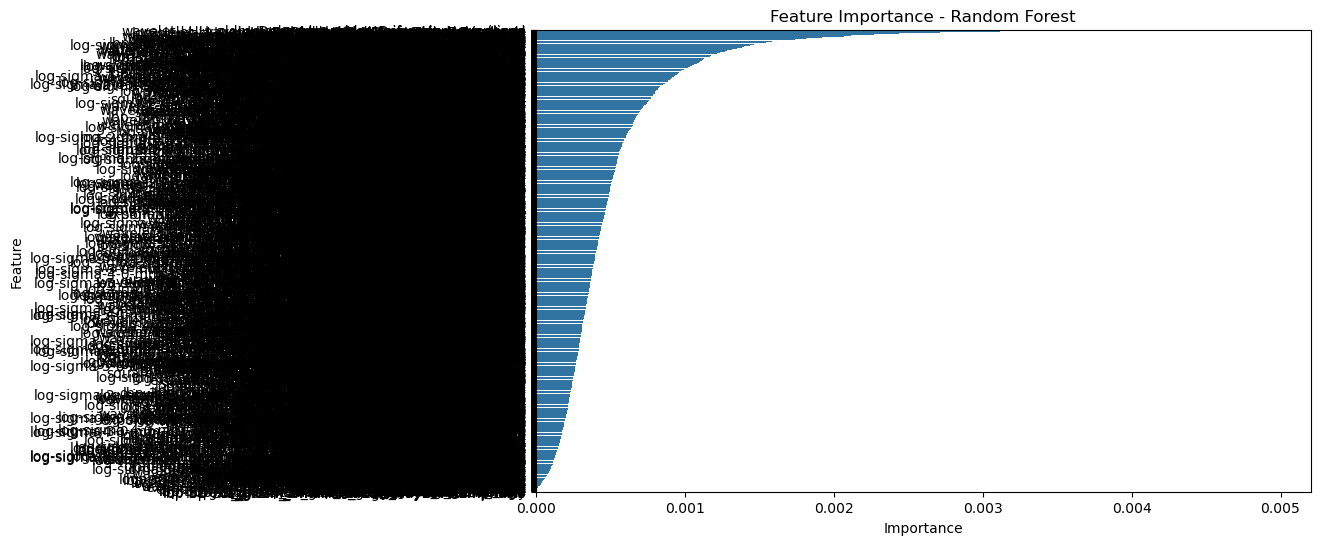

Features Selecionadas: 172

Relatório de Classificação com Features Selecionadas:
              precision    recall  f1-score   support

          AD       0.47      0.29      0.36        24
          CN       0.62      0.79      0.69        42
         MCI       0.54      0.52      0.53        56

    accuracy                           0.57       122
   macro avg       0.54      0.53      0.53       122
weighted avg       0.55      0.57      0.55       122



In [26]:

# Criar instâncias dos modelos
xgbost_origem = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)

random_forest_origem = RandomForestClassifier(n_estimators=800,random_state=34)


#report_xgboost, f1_macro_score_xgboost, f1_macro_std_xgboost = processar_transicoes_com_label_encoder(df,xgbost_origem)
report_random, f1_macro_score_rf, f1_macro_std_rf = gerar_origem(df,random_forest_origem)

